In [5]:
# Necessary imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [9]:
# Import in the data and only take features which we have selected. Drop nans and split into training and test data.

with open("initial_df.pkl", 'rb') as picklefile: 
    df = pickle.load(picklefile)


In [29]:
# Only take the features we are interested in
df = df[['internet_users','agr','gdp_per_capita','pop_below_pov', 'border_internet_scaled']]
df = df.dropna()

# Split into training and test data
df_train,df_test = train_test_split(df, test_size=0.2, random_state = 1)
df_train.head()

,internet_users,agr,gdp_per_capita,pop_below_pov,border_internet_scaled
Country,,,,,
Switzerland,0.887867,0.7,61400.0,6.6,0.800442
Niger,0.041865,41.5,1200.0,45.4,0.243596
Egypt,0.382545,11.9,12700.0,27.8,0.335194
Turkmenistan,0.177887,7.5,18100.0,0.2,0.191081
Canada,0.891823,1.7,48300.0,9.4,0.755633


In [30]:
# Standardise the data by compressing it between 0 and 1.

scaler = MinMaxScaler()
scaler.fit(df_train)
df_train_scaled = pd.DataFrame(scaler.transform(df_train))
df_train_scaled.columns = df_train.columns
df_train_scaled.index = df_train.index

df_train_scaled.describe()


,internet_users,agr,gdp_per_capita,pop_below_pov,border_internet_scaled
count,118.000000,118.000000,118.000000,118.000000,118.000000
mean,0.517756,0.256259,0.166536,0.302546,0.505841
std,0.300536,0.241705,0.185177,0.206428,0.253282
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.226893,0.062651,0.024534,0.172121,0.271300
50%,0.518866,0.180723,0.093674,0.261212,0.532642
75%,0.787766,0.372892,0.248378,0.394545,0.695709
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [31]:
# Standardide the test data by transforming using the fit from the train data.

df_test_scaled = pd.DataFrame(scaler.transform(df_test))
df_test_scaled.columns = df_test.columns
df_test_scaled.index = df_test.index

df_test_scaled.head()

,internet_users,agr,gdp_per_capita,pop_below_pov,border_internet_scaled
Country,,,,,
Panama,0.528589,0.057831,0.196269,0.278788,0.616056
Slovenia,0.769765,0.043373,0.269262,0.168485,0.700337
Grenada,0.553264,0.219277,0.111111,0.460606,0.548819
Poland,0.744647,0.057831,0.229521,0.213333,0.808163
Pakistan,0.119506,0.595181,0.034063,0.357576,0.421953


In [32]:
# Get X and y from the training data

y = df_train_scaled.internet_users
X = df_train_scaled.drop(columns=['internet_users'])

y_test = df_test_scaled.internet_users
X_test = df_test_scaled.drop(columns=['internet_users'])

0.08981832959417128
0.02206850912791681
0.02028068342948218
0.17228059452695305
3.1355630664042566


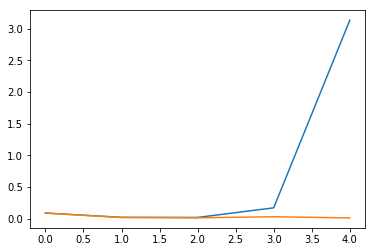

In [33]:
# Looping over different polynomial values to find degree with best mean squared error and r2 values. 
# We found that a linear combination is the best


mse_degree = []
train_degree = []

for i in range(0,5):
    
    # Cross validation
    poly = PolynomialFeatures(degree=i)
    X2 = poly.fit_transform(X)
    reg = LinearRegression()
    scores = cross_val_score(reg, X2, y, cv=10, scoring='neg_mean_squared_error')   
    mse_degree.append(np.mean(-scores))
    print(np.mean(-scores))
    
    # Only on one training
    reg.fit(X2,y)
    training_error = mean_squared_error(y, reg.predict(X2))
    train_degree.append(training_error)
       
plt.plot(mse_degree)
plt.plot(train_degree)

plt.savefig('find_degree.pdf', bbox_inches="tight")

# Best result from degree 2 polynomial.

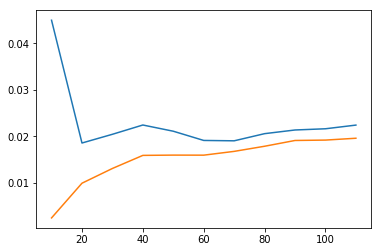

In [36]:
sample_list = list(range(10,120,10))

solo = []
mse_training = []

for i in sample_list:
    df_sample = df_train_scaled.sample(n=i,random_state = 2)
    
    y_sample = df_sample.internet_users
    X_sample = df_sample.drop(columns=['internet_users'])
    reg = LinearRegression()
    scores = cross_val_score(reg, X_sample, y_sample, cv=10, scoring='neg_mean_squared_error')
    mse_training.append(np.mean(-scores))
    
    # Only on one training
    reg.fit(X_sample,y_sample)
    training_error = mean_squared_error(y_sample, reg.predict(X_sample))
    solo.append(training_error)
    
plt.plot(sample_list,mse_training)
plt.plot(sample_list,solo)

plt.savefig('find_train_size.pdf', bbox_inches="tight")

In [40]:
# Perform regularization with degree 2, minimising MSE

from sklearn.cross_validation import KFold
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import make_pipeline


all_scores=[]
alphas= np.linspace(0.0001,0.01,11)
degree = 2

for alpha in alphas:
    
    est = make_pipeline(PolynomialFeatures(degree), ElasticNet(alpha=alpha))
    scores = cross_val_score(est, X, y, cv=10, scoring='neg_mean_squared_error')
    

In [41]:
# Using optimum alpha

optimum_alpha = 0.02

poly = PolynomialFeatures(2)
X2 = poly.fit_transform(X)

est = ElasticNet(alpha=optimum_alpha)
fit = est.fit(X2,y)

# Show the coefficients
fit.coef_

array([ 0.        , -0.3729752 ,  0.19177614, -0.15607423,  0.09775295,
       -0.        ,  0.        , -0.        , -0.        ,  0.        ,
        0.        ,  0.        , -0.        , -0.        ,  0.22136154])

In [42]:
# Test R2 on test data

poly = PolynomialFeatures(2)
X_test2 = poly.fit_transform(X_test)

sklearn.metrics.r2_score(y_test,fit.predict(X_test2))

0.6743885133985262

In [740]:
# Get feature names to know which coefficients go with with features.
poly.get_feature_names()

['1',
 'x0',
 'x1',
 'x2',
 'x3',
 'x0^2',
 'x0 x1',
 'x0 x2',
 'x0 x3',
 'x1^2',
 'x1 x2',
 'x1 x3',
 'x2^2',
 'x2 x3',
 'x3^2']

In [44]:

# Statsmodels gives different coefficients?

y, X = patsy.dmatrices('internet_users ~ agr + gdp_per_capita + pop_below_pov + border_internet_scaled + np.power(border_internet_scaled,2)', data=df_test_scaled, return_type="dataframe")

model = sm.OLS(y, X)

fit = model.fit()

fit.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         internet_users   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     21.11
Date:                Fri, 12 Oct 2018   Prob (F-statistic):           4.46e-08
Time:                        13:45:07   Log-Likelihood:                 24.386
No. Observations:                  30   AIC:                            -36.77
Df Residuals:                      24   BIC:                            -28.36
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               0.4747      0.136      3.494      0.002       0.194       0.755
agr                                    -0.2533      0.115     -2.205      0.037      -0.490      -0.016
gdp_per_capita                          1.0900      0.255      4.273      0.000       0.563       1.616
pop_below_pov                          -0.1352      0.166     -0.813      0.424      -0.478       0.208
border_internet_scaled                 -0.3821      0.400     -0.956      0.348      -1.207       0.442
np.power(border_internet_scaled, 2)     0.5320      0.373      1.427      0.166      -0.237       1.302
==============================================================================
Omnibus:                        1.268   Durbin-Watson:                   2.743
Prob(Omnibus):                  0.530   Jarque-Bera (JB):                1.071
Skew:                          -0.255   Prob(JB):                        0.585
Kurtosis:                       2.228   Cond. No.                         33.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""